In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [152]:
apple_df = yf.download('AAPL', progress=False)
apple_df.index = pd.to_datetime(apple_df.index)

In [153]:
# Tarih aralığını belirleme
start_date = '2024-03-04'
end_date = '2024-04-01'

# Veriyi belirlenen tarih aralığına göre filtreleme
filtered_data = apple_df.loc[start_date:end_date]

# Veriyi sıralama
filtered_data = filtered_data.sort_index()

# Filtrelenmiş veriyi yazdırma
print(filtered_data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-03-04  176.149994  176.899994  173.789993  175.100006  175.100006   
2024-03-05  170.759995  172.039993  169.619995  170.119995  170.119995   
2024-03-06  171.059998  171.240005  168.679993  169.119995  169.119995   
2024-03-07  169.149994  170.729996  168.490005  169.000000  169.000000   
2024-03-08  169.000000  173.699997  168.940002  170.729996  170.729996   
2024-03-11  172.940002  174.380005  172.050003  172.750000  172.750000   
2024-03-12  173.149994  174.029999  171.009995  173.229996  173.229996   
2024-03-13  172.770004  173.190002  170.759995  171.130005  171.130005   
2024-03-14  172.910004  174.309998  172.050003  173.000000  173.000000   
2024-03-15  171.169998  172.619995  170.289993  172.619995  172.619995   
2024-03-18  175.570007  177.710007  173.520004  173.720001  173.720001   
2024-03-19  174.339996  176.610001  17

In [154]:
# Kapanış fiyatlarını içeren bir DataFrame oluşturma
close_prices = apple_df['Close']

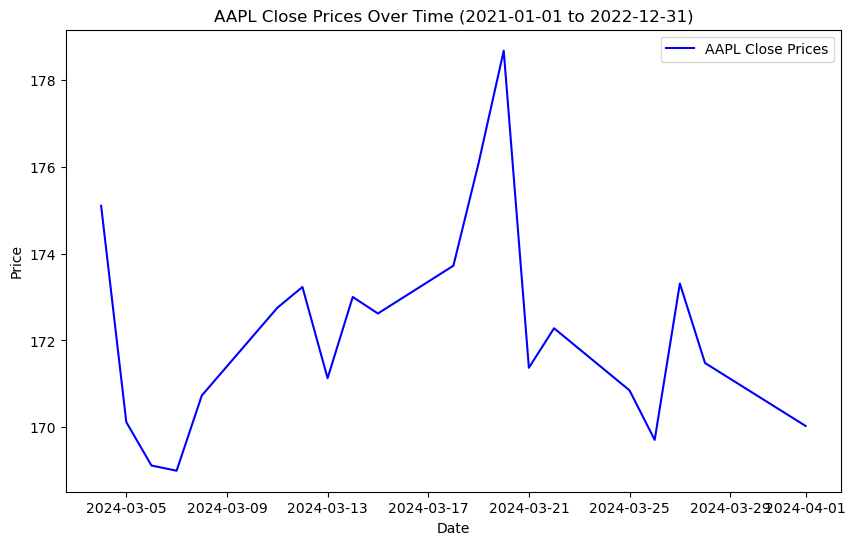

In [155]:
#plt.figure(figsize=(10,6))
#plt.plot(close_prices, label='AAPL Close Prices', color='blue')
#plt.title('AAPL Close Prices Over Time')
#plt.xlabel('Date')
#plt.ylabel('Price')
#plt.legend()
#plt.show()


plt.figure(figsize=(10,6))
plt.plot(filtered_data['Close'], label='AAPL Close Prices', color='blue')
plt.title('AAPL Close Prices Over Time (2021-01-01 to 2022-12-31)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [156]:
# RSI hesaplama
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [157]:
# MACD hesaplama
def calculate_macd(prices, short_period=12, long_period=26, signal_period=9):
    short_ema = prices.ewm(span=short_period, min_periods=1, adjust=False).mean()
    long_ema = prices.ewm(span=long_period, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, min_periods=1, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

In [158]:
# Bollinger Bands hesaplama
def calculate_bollinger_bands(prices, period=20, num_std=2):
    rolling_mean = prices.rolling(window=period, min_periods=1).mean()
    rolling_std = prices.rolling(window=period, min_periods=1).std()

    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, rolling_mean, lower_band


In [159]:
# Risk ve emir yönetimini uygulayalım
initial_capital = 10000  # Başlangıç sermayesi
investment_per_trade = 1000  # Her işlem için yatırım miktarı
stop_loss_pct = 0.03  # Stop-loss yüzdesi (%3)
take_profit_pct = 0.05  # Kar hedefi yüzdesi (%5)

In [160]:
# Alım satım stratejilerini hesaplayan fonksiyonlar
def calculate_long_signals(close_prices, rsi_values, macd, macd_signal, upper_band, lower_band):
    long_rsi_threshold = 40 
    average_true_range = close_prices.diff().abs().rolling(window=14).mean()
    stop_loss = close_prices - (average_true_range * 2)
    take_profit = close_prices + (average_true_range * 3)
    long_buy_signal = (rsi_values < long_rsi_threshold) & (macd > macd_signal) & (close_prices < lower_band) & (close_prices > stop_loss)
    long_sell_signal = (rsi_values > 70) & (macd < macd_signal) & (close_prices > upper_band) & (close_prices < take_profit)
    return long_buy_signal, long_sell_signal

def calculate_short_signals(close_prices, rsi_values, macd, macd_signal, upper_band, lower_band):
    short_rsi_threshold = 40
    short_buy_signal = (rsi_values < short_rsi_threshold) & (macd > macd_signal) & (close_prices < lower_band)
    short_sell_signal = (rsi_values > 60) & (macd < macd_signal) & (close_prices > upper_band)
    return short_buy_signal, short_sell_signal

In [210]:
# Sermaye yönetimi
def manage_trades(filtered_close_prices, filtered_long_buy_signal, filtered_long_sell_signal, filtered_short_buy_signal, filtered_short_sell_signal, initial_capital, investment_per_trade, stop_loss_pct, take_profit_pct):
    if len(filtered_close_prices) != len(filtered_long_buy_signal) or len(filtered_close_prices) != len(filtered_long_sell_signal) or len(filtered_close_prices) != len(filtered_short_buy_signal) or len(filtered_close_prices) != len(filtered_short_sell_signal):
        raise ValueError("Length mismatch: filtered_close_prices, filtered_long_buy_signal, filtered_long_sell_signal, filtered_short_buy_signal, and filtered_short_sell_signal must have the same length.")
    
    capital = initial_capital
    positions = []
    
    for i in range(len(filtered_close_prices)):
        if filtered_long_buy_signal[i]:
            entry_price = filtered_close_prices[i]
            stop_loss = entry_price * (1 - stop_loss_pct)
            take_profit = entry_price * (1 + take_profit_pct)
            quantity = min(capital // entry_price, investment_per_trade)
            capital -= quantity * entry_price
            positions.append(('long', entry_price, quantity, stop_loss, take_profit))
        elif filtered_long_sell_signal[i]:
            entry_price = filtered_close_prices[i]
            stop_loss = entry_price * (1 + stop_loss_pct)
            take_profit = entry_price * (1 - take_profit_pct)
            quantity = min(capital // entry_price, investment_per_trade)
            capital -= quantity * entry_price
            positions.append(('short', entry_price, quantity, stop_loss, take_profit))
        elif filtered_short_buy_signal[i]:
            entry_price = filtered_close_prices[i]
            stop_loss = entry_price * (1 - stop_loss_pct)
            take_profit = entry_price * (1 + take_profit_pct)
            quantity = min(capital // entry_price, investment_per_trade)
            capital += quantity * entry_price
            positions.append(('short', entry_price, quantity, stop_loss, take_profit))
        elif filtered_short_sell_signal[i]:
            entry_price = filtered_close_prices[i]
            stop_loss = entry_price * (1 + stop_loss_pct)
            take_profit = entry_price * (1 - take_profit_pct)
            quantity = min(capital // entry_price, investment_per_trade)
            capital += quantity * entry_price
            positions.append(('long', entry_price, quantity, stop_loss, take_profit))
        
        # Update existing positions
        updated_positions = []
        for position_type, entry_price, quantity, stop_loss, take_profit in positions:
            if position_type == 'long':
                if filtered_close_prices[i] <= stop_loss or filtered_close_prices[i] >= take_profit:
                    capital += quantity * filtered_close_prices[i]
                else:
                    updated_positions.append((position_type, entry_price, quantity, stop_loss, take_profit))
            elif position_type == 'short':
                if filtered_close_prices[i] >= stop_loss or filtered_close_prices[i] <= take_profit:
                    capital += quantity * filtered_close_prices[i]
                else:
                    updated_positions.append((position_type, entry_price, quantity, stop_loss, take_profit))
        positions = updated_positions
    
    # Close remaining positions
    for position_type, entry_price, quantity, _, _ in positions:
        if position_type == 'long':
            capital += quantity * filtered_close_prices[-1]
        elif position_type == 'short':
            capital -= quantity * filtered_close_prices[-1]
    
    return capital

In [211]:
# RSI ve MACD hesaplama
filtered_rsi_values = calculate_rsi(filtered_data['Close'])
filtered_macd, filtered_macd_signal, _ = calculate_macd(filtered_data['Close'])

In [212]:
#Bollinger Bantları hesaplama
filtered_upper_band, _, filtered_lower_band = calculate_bollinger_bands(filtered_data['Close'])

In [213]:
# Alım satım sinyallerini hesaplayalım
filtered_long_buy_signal, filtered_long_sell_signal = calculate_long_signals(filtered_data['Close'], filtered_rsi_values, filtered_macd, filtered_macd_signal, filtered_upper_band, filtered_lower_band)
filtered_short_buy_signal, filtered_short_sell_signal = calculate_short_signals(filtered_data['Close'], filtered_rsi_values, filtered_macd, filtered_macd_signal, filtered_upper_band, filtered_lower_band)


In [214]:
final_capital = manage_trades(filtered_data['Close'], filtered_long_buy_signal, filtered_long_sell_signal, filtered_short_buy_signal, filtered_short_sell_signal, initial_capital, investment_per_trade, stop_loss_pct, take_profit_pct)
print("Final Capital:", final_capital)

Final Capital: 10000


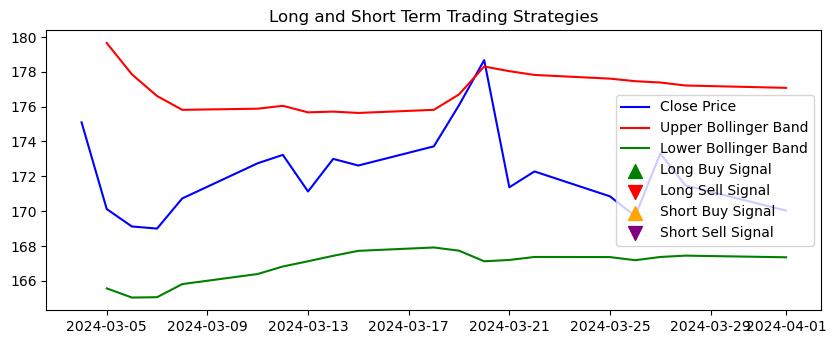

In [166]:
# Kapanış fiyatlarını plot etme
plt.figure(figsize=(10, 8)) 
plt.subplot(2, 1, 1)
plt.plot(filtered_data['Close'], label='Close Price', color='blue')
plt.plot(filtered_upper_band, label='Upper Bollinger Band', color='red')
plt.plot(filtered_lower_band, label='Lower Bollinger Band', color='green')
plt.scatter(filtered_data[filtered_long_buy_signal].index, filtered_data['Close'][filtered_long_buy_signal], marker='^', color='green', label='Long Buy Signal', s=100)
plt.scatter(filtered_data[filtered_long_sell_signal].index, filtered_data['Close'][filtered_long_sell_signal], marker='v', color='red', label='Long Sell Signal', s=100)
plt.scatter(filtered_data[filtered_short_buy_signal].index, filtered_data['Close'][filtered_short_buy_signal], marker='^', color='orange', label='Short Buy Signal', s=100)
plt.scatter(filtered_data[filtered_short_sell_signal].index, filtered_data['Close'][filtered_short_sell_signal], marker='v', color='purple', label='Short Sell Signal', s=100)
plt.title('Long and Short Term Trading Strategies')
plt.legend()
plt.show()


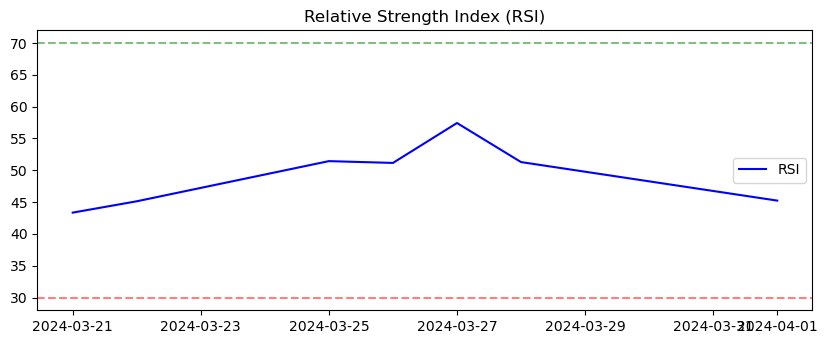

In [167]:
# RSI plot etme
plt.figure(figsize=(10, 8)) 
plt.subplot(2, 1, 2)
plt.plot(filtered_rsi_values, label='RSI', color='blue')
plt.axhline(30, linestyle='--', color='red', alpha=0.5)
plt.axhline(70, linestyle='--', color='green', alpha=0.5)
plt.title('Relative Strength Index (RSI)')
plt.legend()


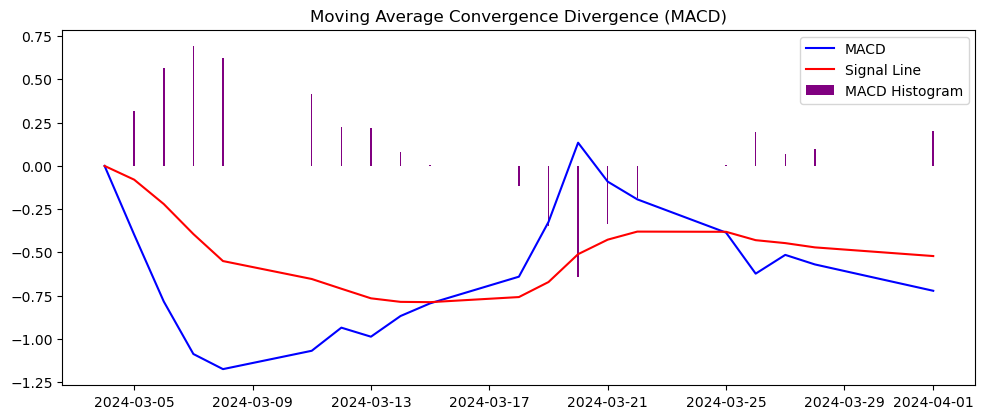

In [168]:
# MACD ve sinyal hattı plot etme
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 2)
plt.plot(filtered_macd, label='MACD', color='blue')
plt.plot(filtered_macd_signal, label='Signal Line', color='red')
plt.bar(filtered_macd.index, filtered_macd_signal - filtered_macd, width=0.05, label='MACD Histogram', color='purple')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.legend()
plt.tight_layout()
plt.show()


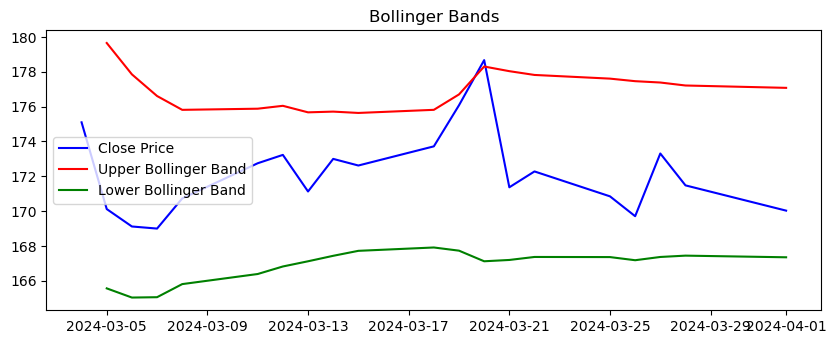

In [169]:
# Bollinger Bantları plot etme
plt.figure(figsize=(10, 8)) 
plt.subplot(2, 1, 2)
plt.plot(filtered_data['Close'], label='Close Price', color='blue')
plt.plot(filtered_upper_band, label='Upper Bollinger Band', color='red')
plt.plot(filtered_lower_band, label='Lower Bollinger Band', color='green')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

In [170]:
data = apple_df.sort_index()

In [171]:
# Geriye dönük test dönemi
start_date = '2024-01-02'
end_date = '2024-02-05'


In [172]:
# Belirlenen döneme ait verileri seçme
backtest_data = data[start_date:end_date]
backtest_close_prices = backtest_data['Close']


In [173]:
# Alım satım sinyallerini yeniden hesaplama
backtest_rsi_values = calculate_rsi(backtest_close_prices)
backtest_macd, backtest_macd_signal, _ = calculate_macd(backtest_close_prices)
backtest_upper_band, _, backtest_lower_band = calculate_bollinger_bands(backtest_close_prices)
backtest_long_buy_signal, backtest_long_sell_signal = calculate_long_signals(backtest_close_prices, backtest_rsi_values, backtest_macd, backtest_macd_signal, backtest_upper_band, backtest_lower_band)
backtest_short_buy_signal, backtest_short_sell_signal = calculate_short_signals(backtest_close_prices, backtest_rsi_values, backtest_macd, backtest_macd_signal, backtest_upper_band, backtest_lower_band)


In [174]:
# Geriye dönük test
backtest_initial_capital = 10000  # Başlangıç sermayesi
backtest_investment_per_trade = 1000  # Her işlem için yatırım miktarı
backtest_stop_loss_pct = 0.03  # Stop-loss yüzdesi (%3)
backtest_take_profit_pct = 0.05  # Kar hedefi yüzdesi (%5)
backtest_final_capital = manage_trades(backtest_close_prices, backtest_long_buy_signal, backtest_long_sell_signal, backtest_short_buy_signal, backtest_short_sell_signal, backtest_initial_capital, backtest_investment_per_trade, backtest_stop_loss_pct, backtest_take_profit_pct)
print("Geriye Dönük Test Sonucu - Final Sermaye:", backtest_final_capital)


Geriye Dönük Test Sonucu - Final Sermaye: 10000


In [175]:
# Performans ölçümü
backtest_total_profit = backtest_final_capital - backtest_initial_capital
backtest_total_trades = len(backtest_long_buy_signal) + len(backtest_short_buy_signal)
backtest_average_profit_per_trade = backtest_total_profit / backtest_total_trades
backtest_percentage_return = (backtest_total_profit / backtest_initial_capital) * 100

print("Toplam Kar:", backtest_total_profit)
print("Toplam İşlem Sayısı:", backtest_total_trades)
print("Ortalama İşlem Karı:", backtest_average_profit_per_trade)
print("Yüzde Getiri:", backtest_percentage_return)

Toplam Kar: 0
Toplam İşlem Sayısı: 48
Ortalama İşlem Karı: 0.0
Yüzde Getiri: 0.0


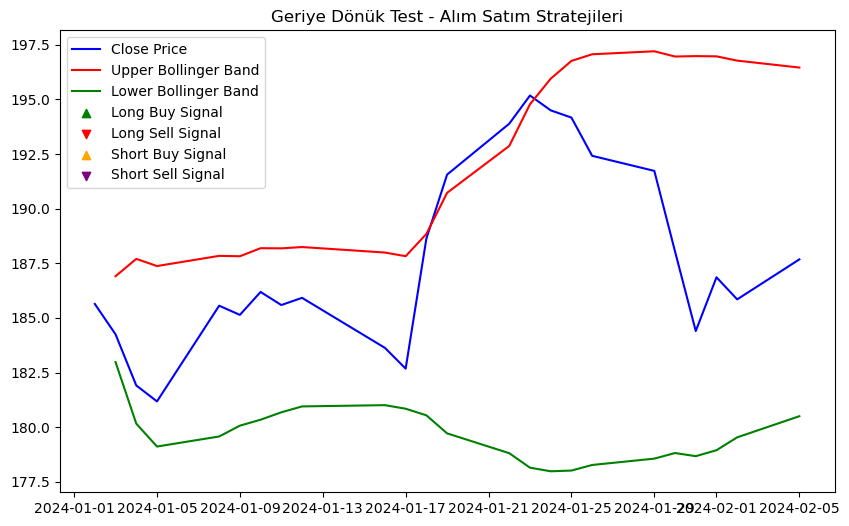

In [176]:
# Performansı görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(backtest_close_prices, label='Close Price', color='blue')
plt.plot(backtest_upper_band, label='Upper Bollinger Band', color='red')
plt.plot(backtest_lower_band, label='Lower Bollinger Band', color='green')
plt.scatter(backtest_close_prices[backtest_long_buy_signal].index, backtest_close_prices[backtest_long_buy_signal], marker='^', color='green', label='Long Buy Signal')
plt.scatter(backtest_close_prices[backtest_long_sell_signal].index, backtest_close_prices[backtest_long_sell_signal], marker='v', color='red', label='Long Sell Signal')
plt.scatter(backtest_close_prices[backtest_short_buy_signal].index, backtest_close_prices[backtest_short_buy_signal], marker='^', color='orange', label='Short Buy Signal')
plt.scatter(backtest_close_prices[backtest_short_sell_signal].index, backtest_close_prices[backtest_short_sell_signal], marker='v', color='purple', label='Short Sell Signal')
plt.title('Geriye Dönük Test - Alım Satım Stratejileri')
plt.legend()
plt.show()


In [177]:
#Veriyi yeniden boyutlandırma ve normalleştirme
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(np.array(close_prices).reshape(-1, 1))

In [178]:
#LSTM için veri setinin oluşturulması
def create_dataset(dataset, time_step=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0])
    return np.array(data_X), np.array(data_Y)

In [179]:
#Zaman serisi veri setini eğitim ve test setlerine bölelim
train_size = int(len(close_prices_scaled) * 0.7)
test_size = len(close_prices_scaled) - train_size
train, test = close_prices_scaled[0:train_size,:], close_prices_scaled[train_size:len(close_prices_scaled),:]

In [180]:
# Zaman serisi veri setini LSTM giriş formatına dönüştürelim
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [181]:
# LSTM modelinin oluşturulması
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

C:\Users\fatih\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [182]:
# Modelin derlenmesi
model.compile(optimizer='adam', loss='mean_squared_error')

In [183]:
# Modelin eğitilmesi
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, verbose=1)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - loss: 7.3875e-05 - val_loss: 0.0032
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - loss: 3.1463e-06 - val_loss: 0.0021
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - loss: 2.5527e-06 - val_loss: 0.0025
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - loss: 3.1749e-06 - val_loss: 0.0014
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - loss: 2.1134e-06 - val_loss: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - loss: 2.8624e-06 - val_loss: 0.0011
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - loss: 2.5870e-06 - val_loss: 4.8802e-04
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - loss: 2.6452e-06 - val_loss: 4.9215e-04
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - loss: 2.1671e-06 - val_loss: 8.9571e-04
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - loss: 2.6081e-06 - val_loss: 0.0021
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step -

In [184]:
# Eğitilmiş model ile tahminler yapma
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


In [185]:
# Normalleştirmeyi tersine çevirme
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [186]:
# Eğitim ve test setlerindeki ortalama karesel hata
print('Eğitim Seti Ortalama Kare Hatası:', np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Seti Ortalama Kare Hatası:', np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Eğitim Seti Ortalama Kare Hatası: 0.26106087499220687
Test Seti Ortalama Kare Hatası: 3.468948385519851


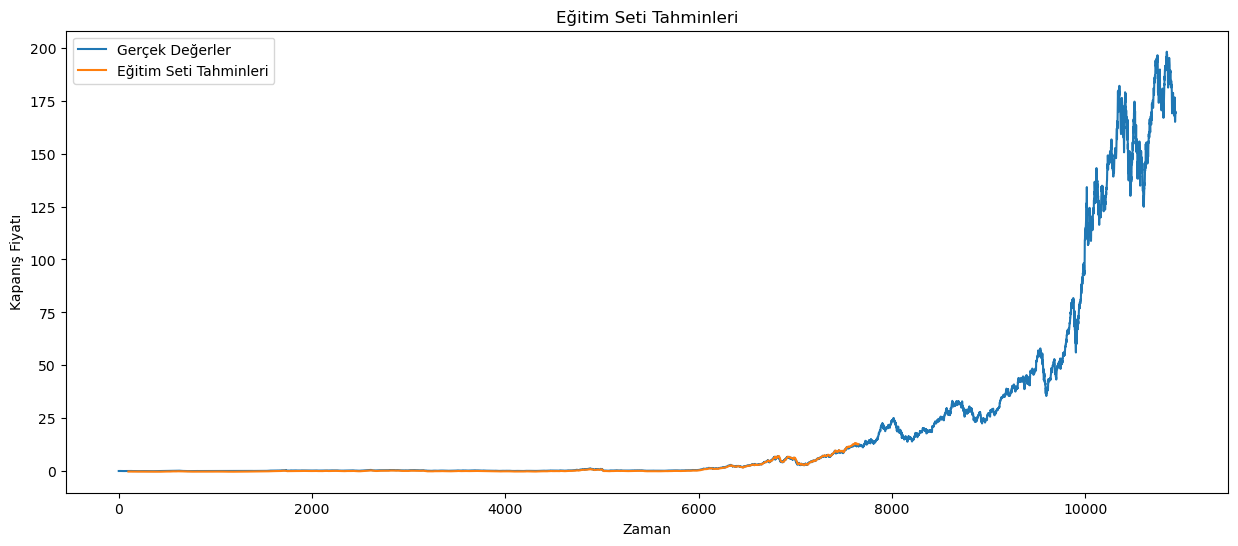

In [187]:
# Eğitim seti tahminlerinin ve gerçek değerlerin zaman serisi grafiği
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(close_prices_scaled), label='Gerçek Değerler')
plt.plot(np.concatenate([np.nan*np.ones((time_step,1)), train_predict]), label='Eğitim Seti Tahminleri')
plt.xlabel('Zaman')
plt.ylabel('Kapanış Fiyatı')
plt.title('Eğitim Seti Tahminleri')
plt.legend()
plt.show()

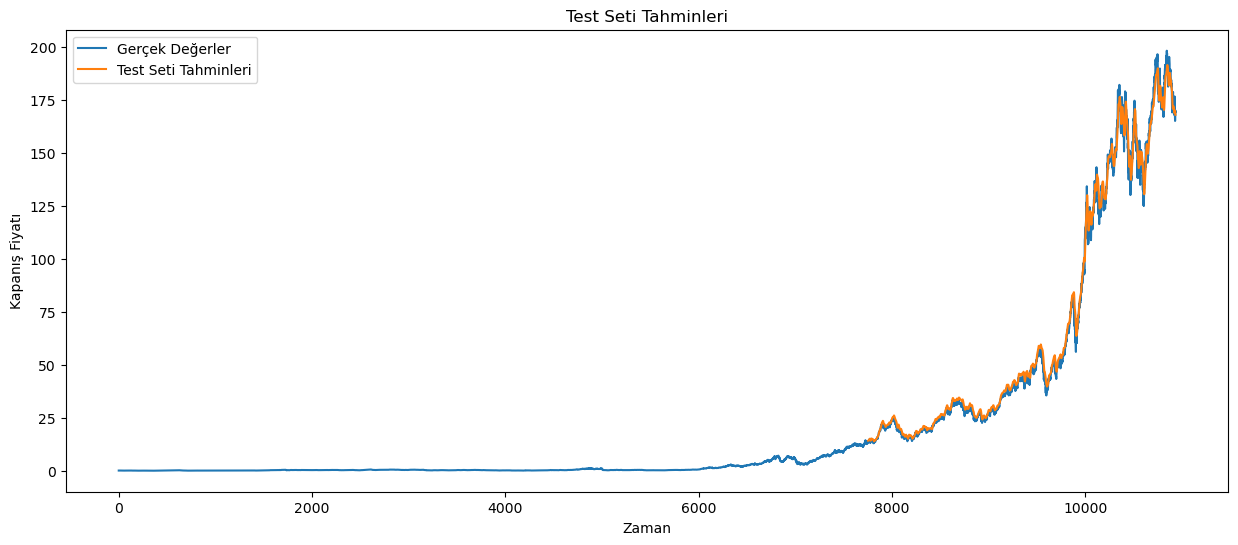

In [188]:
# Test seti tahminlerinin ve gerçek değerlerin zaman serisi grafiği
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(close_prices_scaled), label='Gerçek Değerler')
plt.plot(np.concatenate([np.nan*np.ones((train_size+time_step,1)), test_predict]), label='Test Seti Tahminleri')
plt.xlabel('Zaman')
plt.ylabel('Kapanış Fiyatı')
plt.title('Test Seti Tahminleri')
plt.legend()
plt.show()